In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# import regularizers
from tensorflow.keras import regularizers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
!nvidia-smi

Fri Nov 25 12:35:29 2022       

+-----------------------------------------------------------------------------+

| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |

|-------------------------------+----------------------+----------------------+

| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |

| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |

|                               |                      |               MIG M. |

|===============================+======================+======================|

|   0  NVIDIA GeForce ... WDDM  | 00000000:57:00.0 Off |                  N/A |

| N/A   47C    P5     9W /  N/A |      0MiB /  4096MiB |      0%      Default |

|                               |                      |                  N/A |

+-------------------------------+----------------------+----------------------+

                                                                            

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182082353/182082353 [==============================] - 9s 0us/step


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # sample rate
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.

Using 6400 files for training.

Using 1600 files for validation.



label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)

(64,)


## Raw Sound Waves

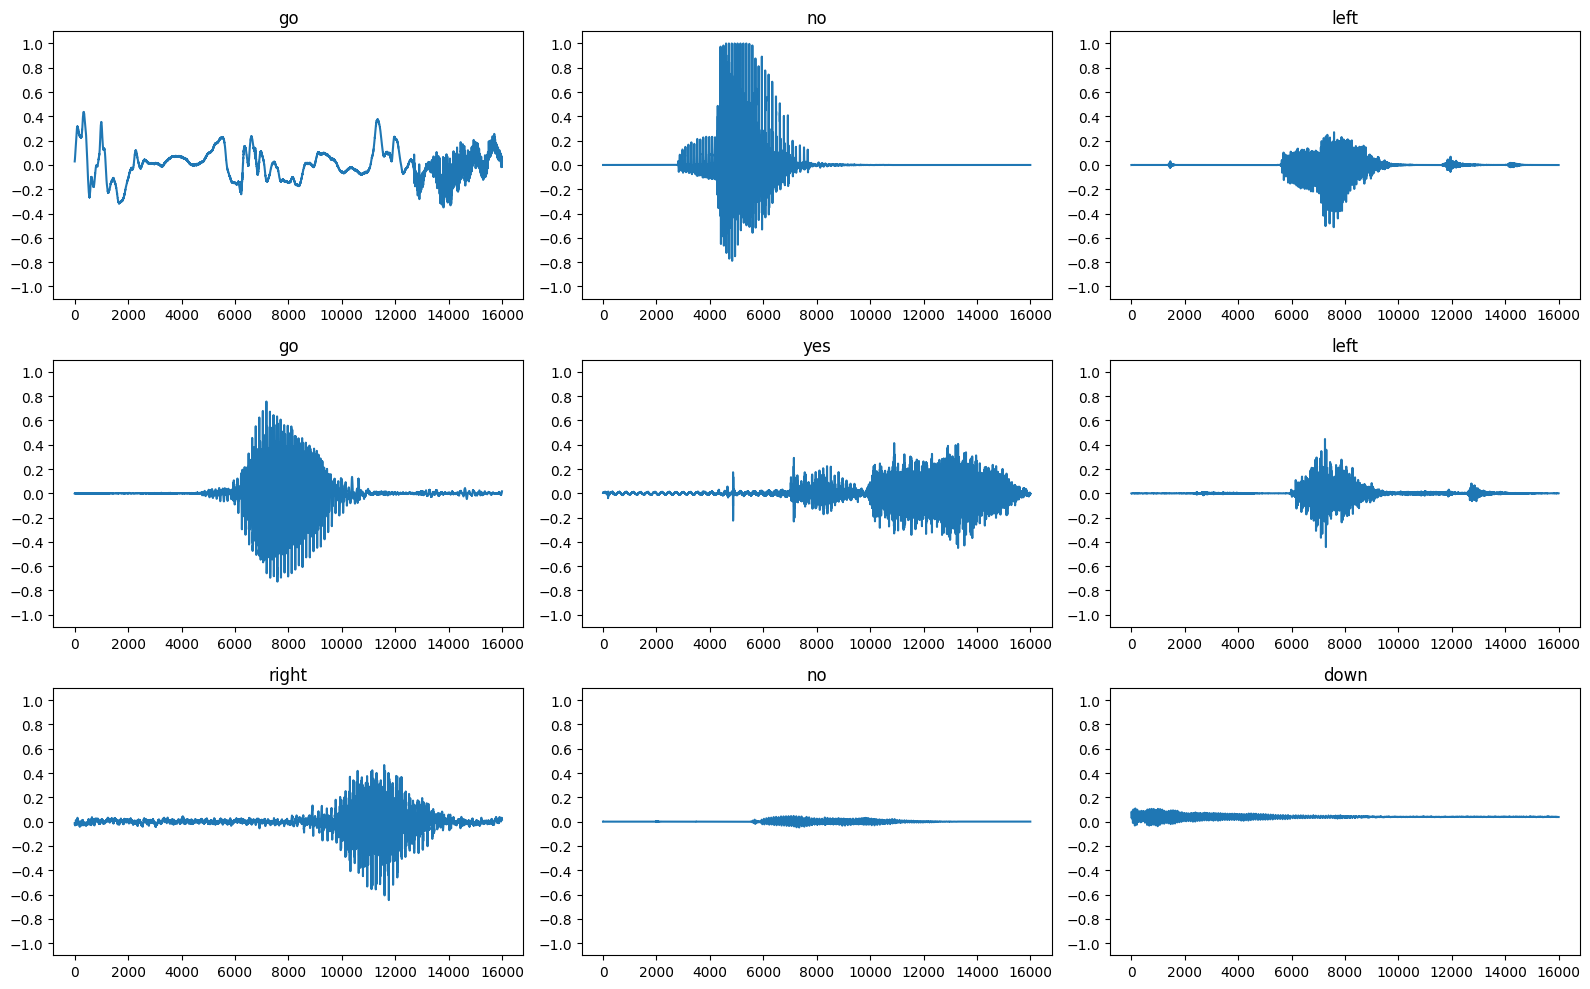

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))

for idx, ax in enumerate(axes.flatten()):
    ax.plot(example_audio[idx].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[idx]]
    ax.set_title(label)
    ax.set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()

## Converting Sound Waves to Spectrograms

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  
  return spectrogram

In [14]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: go

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback


Label: no

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback


Label: left

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax, cmap):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, cmap=cmap)

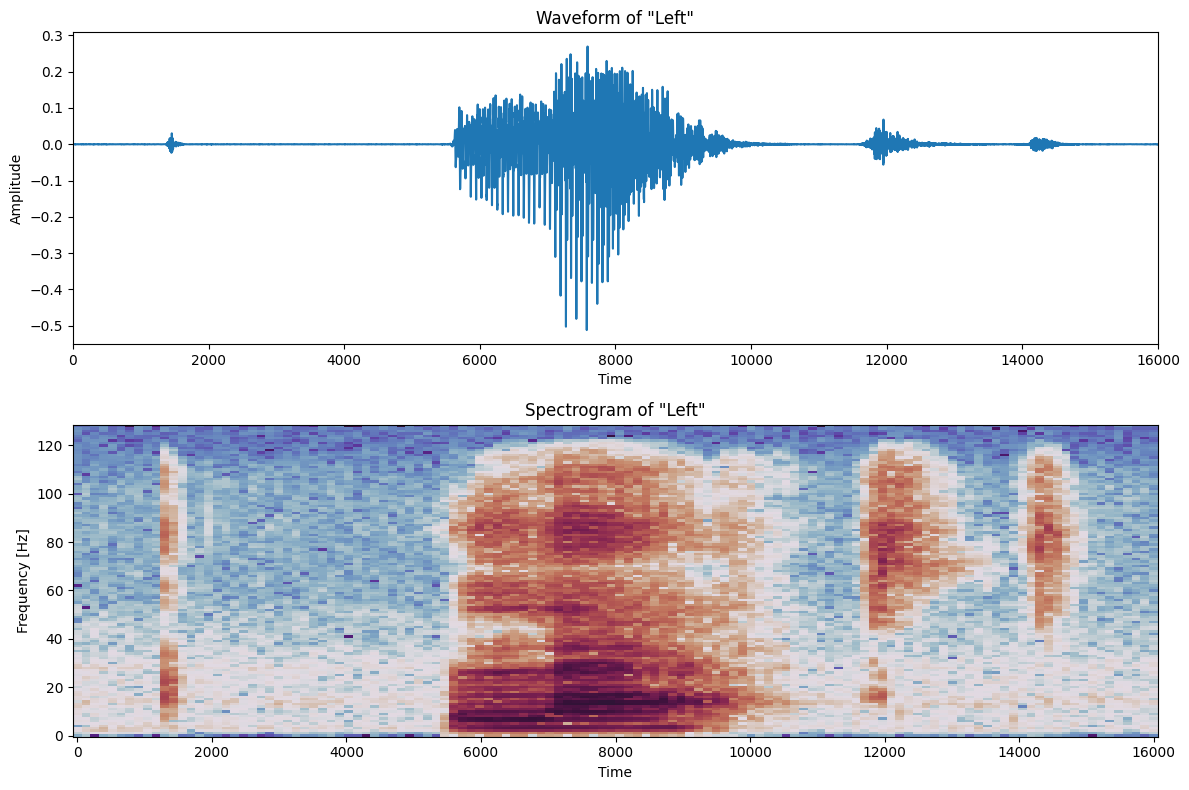

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Waveform of "Left"')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), ax=axes[1], cmap='twilight_shifted')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency [Hz]')
axes[1].set_title('Spectrogram of "Left"')

plt.tight_layout()
plt.show()

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [20]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

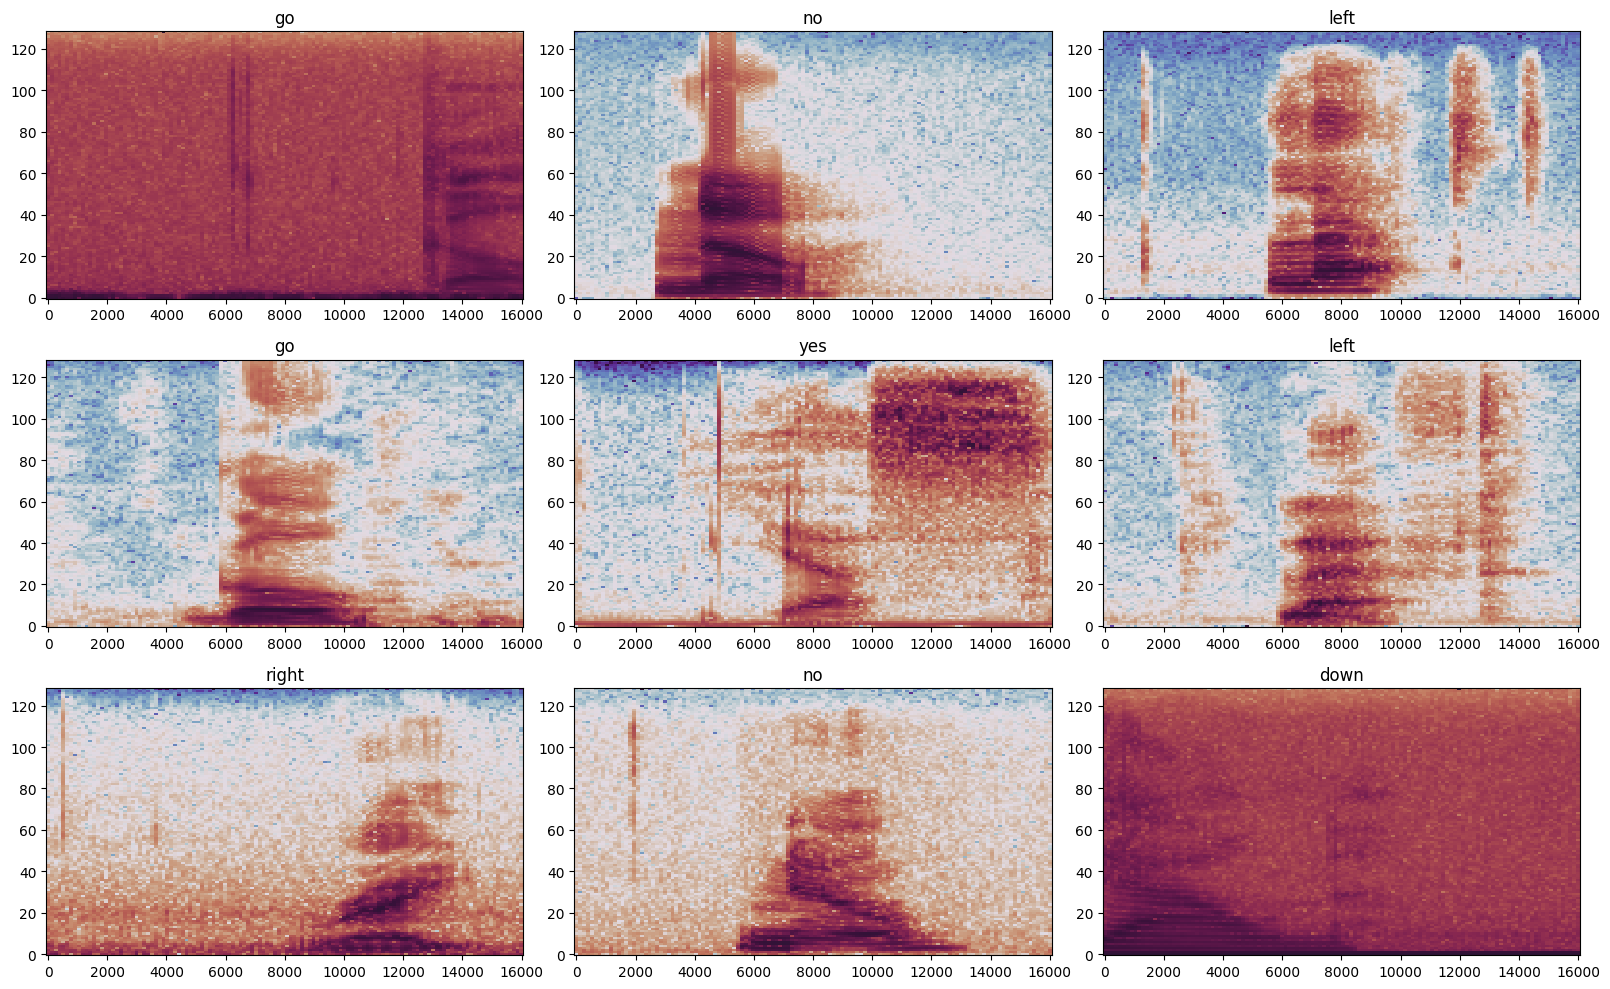

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))

for idx, ax in enumerate(axes.flatten()):
    spectrogram = get_spectrogram(example_audio[idx])
    plot_spectrogram(spectrogram.numpy(), ax, cmap='twilight_shifted')
    ax.set_title(label_names[example_labels[idx]])

plt.tight_layout()
plt.show()

## Convert to Mel Spectrogram to Decibel Scale

c:\Users\timot\anaconda3\envs\gpu_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  return f(*args, **kwargs)


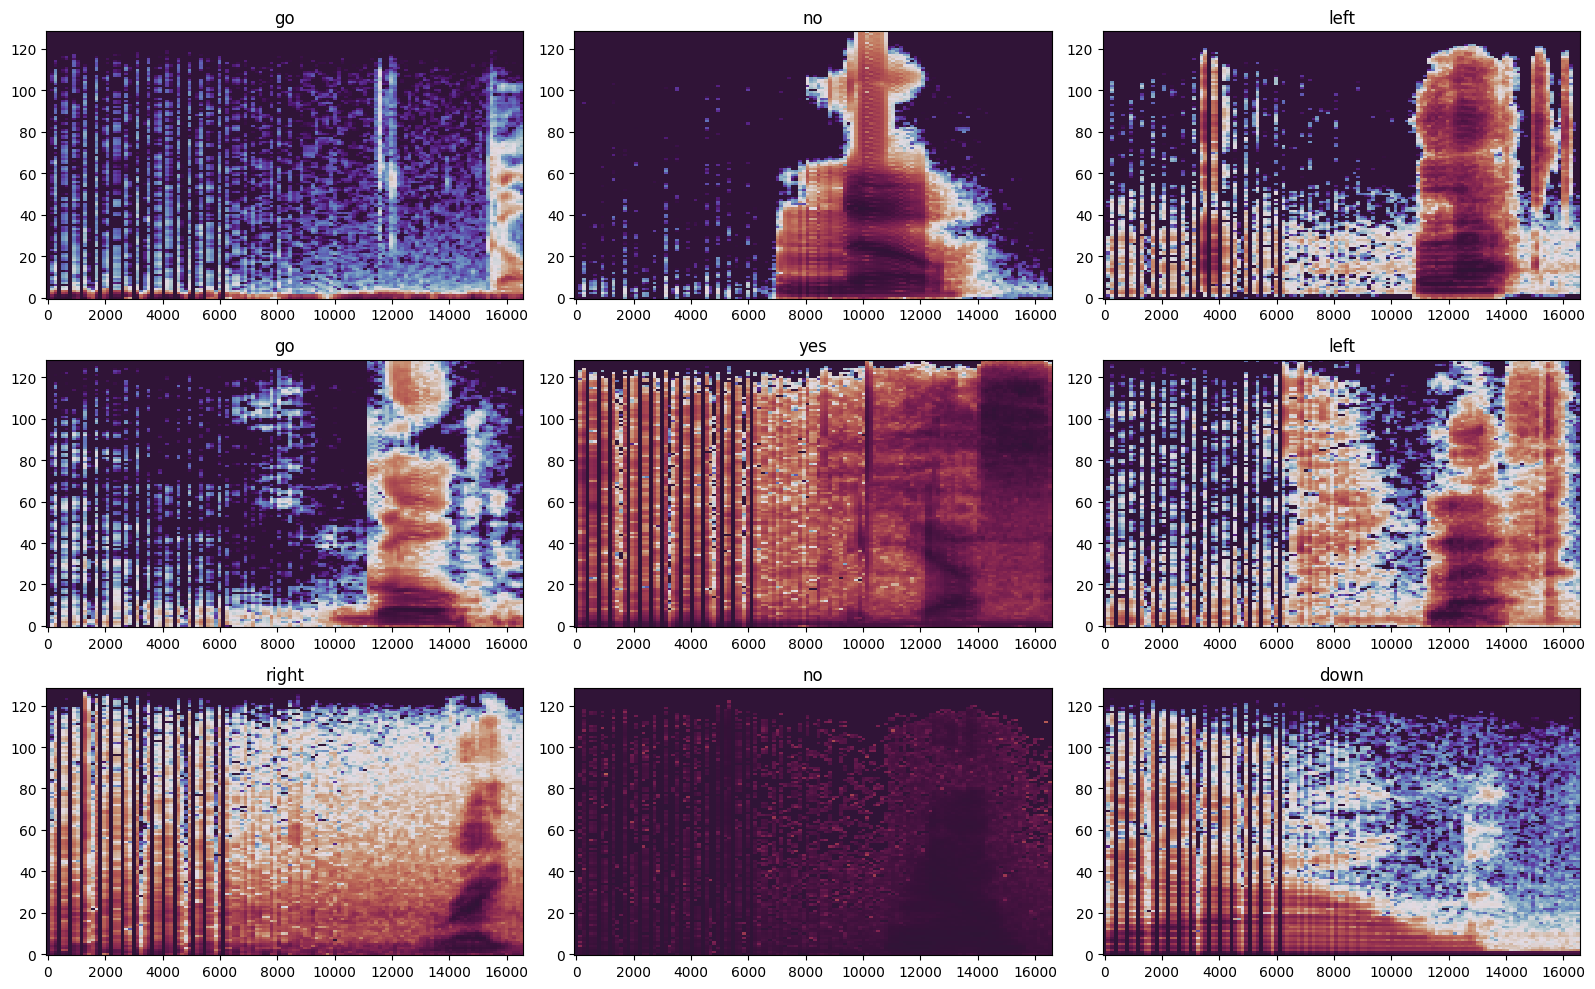

In [22]:
from librosa import amplitude_to_db
from librosa.feature import melspectrogram

# convert to mel spectrogram
def get_melspectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Convert to mel spectrogram
    mel_spectrogram = melspectrogram(S=spectrogram.numpy(), sr=16000)
    # Convert tp decibel scale
    mel_spectrogram = amplitude_to_db(mel_spectrogram, ref=np.min)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]

    return mel_spectrogram

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))

for idx, ax in enumerate(axes.flatten()):
    mel_spectrogram = get_melspectrogram(example_audio[idx])
    plot_spectrogram(mel_spectrogram, ax, cmap='twilight_shifted')
    ax.set_title(label_names[example_labels[idx]])

plt.tight_layout()
plt.show()

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Build Model

In [24]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
], name='simple_convnet')


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Input shape: (124, 129, 1)

Model: "simple_convnet"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resizing (Resizing)         (None, 32, 32, 1)         0         

                                                                 

 normalization (Normalizatio  (None, 32, 32, 1)        3         

 n)                                                              

                                                                 

 conv2d (Conv2D)             (None, 32, 32, 32)        320       

                                                                 

 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      

                                                                 

 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         

 )                                                               

                                                                 

 dropout

In [32]:
# import plot_model
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train Model

In [25]:
EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)
)

Epoch 1/200

100/100 [==============================] - 17s 90ms/step - loss: 3.2733 - accuracy: 0.1425 - val_loss: 3.1697 - val_accuracy: 0.1836

Epoch 2/200

100/100 [==============================] - 3s 29ms/step - loss: 3.0637 - accuracy: 0.1919 - val_loss: 2.9380 - val_accuracy: 0.2227

Epoch 3/200

100/100 [==============================] - 3s 33ms/step - loss: 2.8671 - accuracy: 0.2463 - val_loss: 2.7063 - val_accuracy: 0.3229

Epoch 4/200

100/100 [==============================] - 4s 38ms/step - loss: 2.6399 - accuracy: 0.3145 - val_loss: 2.4626 - val_accuracy: 0.4076

Epoch 5/200

100/100 [==============================] - 4s 39ms/step - loss: 2.4240 - accuracy: 0.3753 - val_loss: 2.2093 - val_accuracy: 0.4596

Epoch 6/200

100/100 [==============================] - 3s 31ms/step - loss: 2.2806 - accuracy: 0.4209 - val_loss: 2.0655 - val_accuracy: 0.5612

Epoch 7/200

100/100 [==============================] - 3s 31ms/step - loss: 2.1407 - accuracy: 0.4714 - val_loss: 1.8996 -

## Model Evaluation

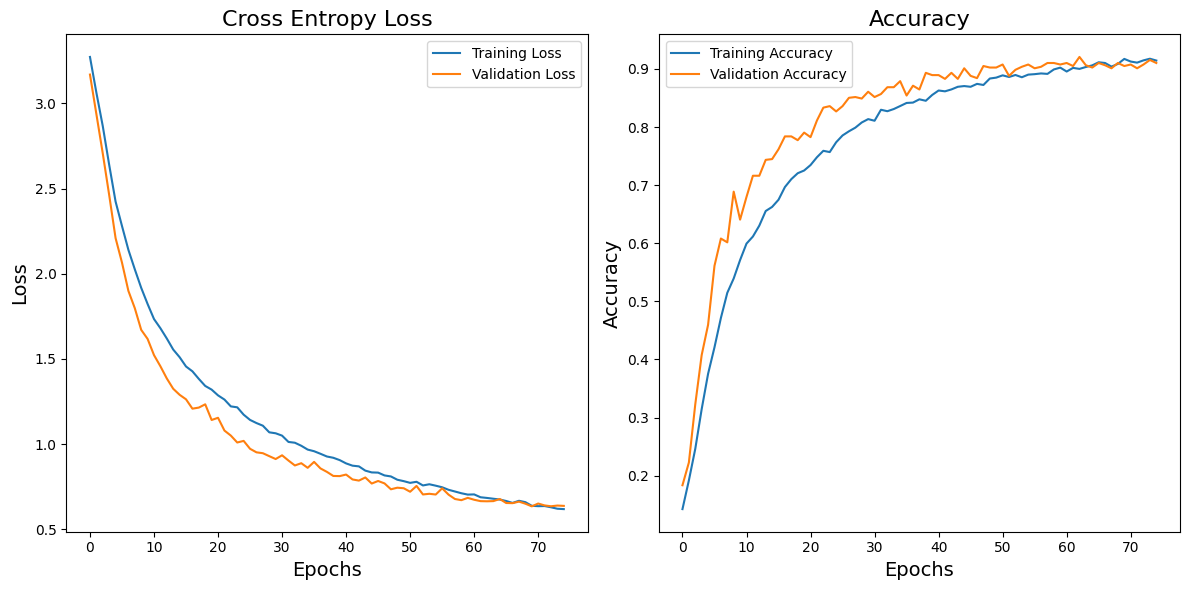

In [26]:
def plot_LC(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Cross Entropy Loss', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend()

    ax[1].plot(acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_LC(history)

In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 83ms/step - loss: 0.6186 - accuracy: 0.9135


{'loss': 0.6186447143554688, 'accuracy': 0.9134615659713745}

In [28]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

13/13 [==============================] - 1s 12ms/step


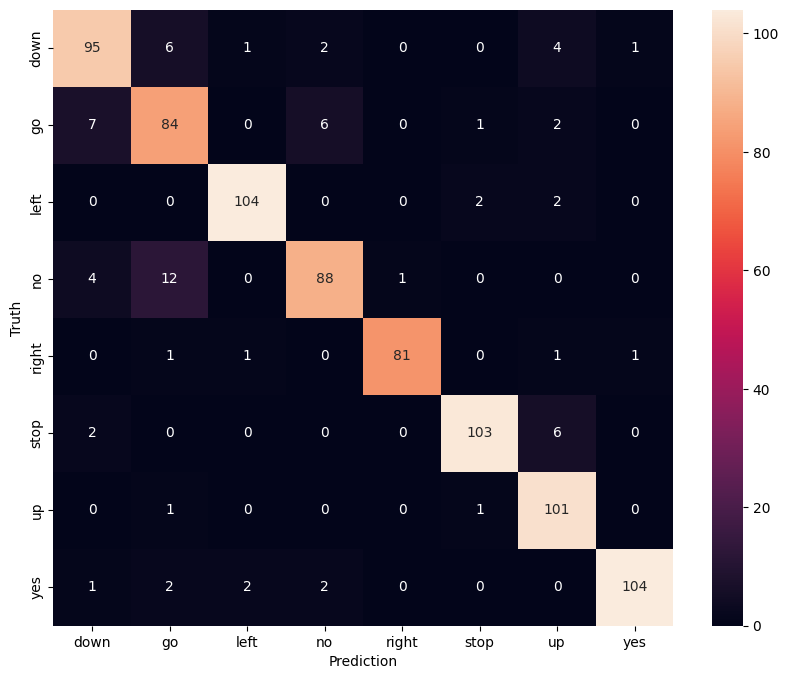

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

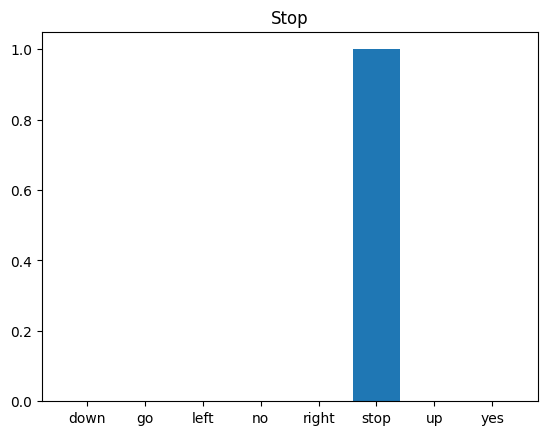

In [30]:
x = data_dir/'stop/0b40aa8e_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('Stop')
plt.show()

display.display(display.Audio(waveform, rate=16000))